In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import SOG_loader
import carbonate
import yaml
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy import signal
from scipy.io import loadmat
from matplotlib import gridspec

%matplotlib inline

## SOG TA Data

In [3]:
# Load GRL2016 data
infil = np.loadtxt('/home/bmoorema/Desktop/grl2016.raw')
crid = infil[:,0]
stn = infil[:,3]
mnth = infil[:,4]
day = infil[:,5]
S = infil[:,10]
alk = infil[:,15]
alk_qf = infil[:,16]

In [4]:
# Load Fraser Record
R = loadmat('/ocean/rich/home/metro/fraser/FRASER.mat')
dates = [
    datetime.fromordinal(int(mtime[0]) - 366) +
    timedelta(days=float(mtime)%1)
    for mtime in R['fraser'][0][0][1]
]
flows = R['fraser'][0][0][2].flatten()

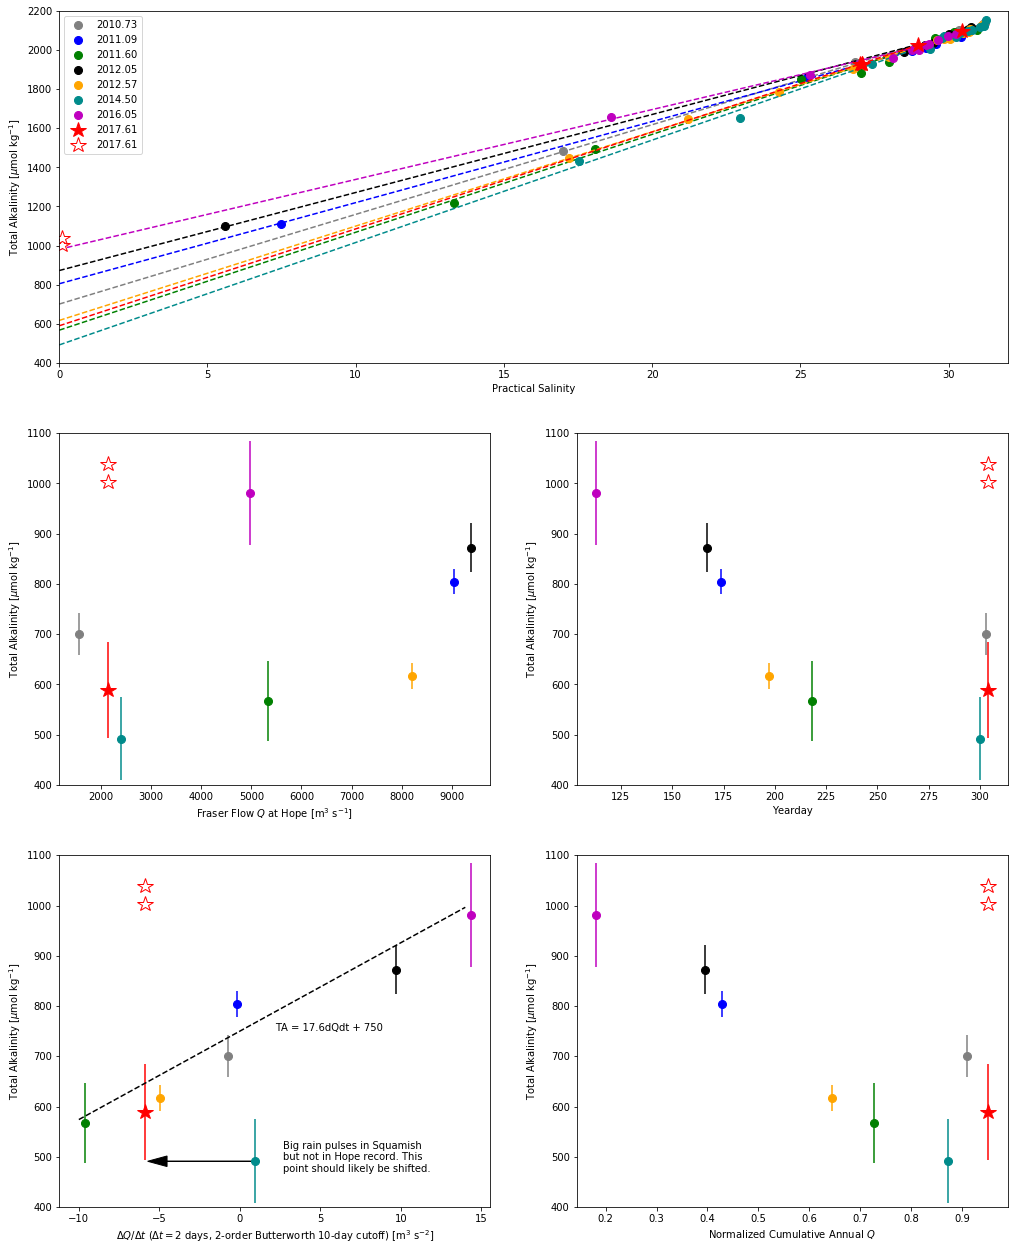

In [5]:
# Cruises to plot
cruises = [2010.73, 2011.09, 2011.60, 2012.05, 2012.57, 2014.50, 2016.05, 2017.61, 2017.61]
stations = [39.5, 42., 39.5, 42., 39.5, 42., 42., 1.5, 0.5]
colors = ['gray', 'b', 'g', 'k', 'orange', 'darkcyan', 'm', 'r', 'r']

# Make figure
fig = plt.figure(figsize=(17, 22))
gs = gridspec.GridSpec(3, 2)
axs = [fig.add_subplot(gs[0, :])]
axs.extend([fig.add_subplot(gs[1, col]) for col in range(2)])
axs.extend([fig.add_subplot(gs[2, col]) for col in range(2)])

# Plot Formatting and Labels
axs[0].set_xlim([0, 32])
axs[0].set_ylim([400, 2200])
axs[0].set_xlabel('Practical Salinity')
axs[0].set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')
labels = [
    'Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]',
    'Yearday',
    '$\Delta Q/\Delta t$ ($\Delta t = 2$ days, 2-order Butterworth 10-day cutoff) [m$^{3}$ s$^{-2}$]',
    'Normalized Cumulative Annual $Q$',
]
for ax, label in zip(axs[1:], labels):
    ax.set_ylim([400, 1100])
    ax.set_xlabel(label)
    ax.set_ylabel('Total Alkalinity [$\mu$mol kg$^{-1}$]')

x_reg, y_reg = [], []    

# Loop through cruises
for cruise, station, color, flow in zip(cruises, stations, colors, flows):
    
    # Symbols
    if color is 'r':
        marker = '*'
        size = 16
    else:
        marker = 'o'
        size = 8
    
    # Index
    index = (crid == cruise) & (stn == station) & ((alk_qf == 2) | (alk_qf == 6))
    
    # Regressions
    if station == 0.5:
        facecolor = 'w'
    else:
        facecolor = color
        model = sm.OLS(alk[index], sm.add_constant(S[index])).fit()
    
    # Flow metrics
    B, A = signal.butter(2, 0.2)
    flows_filter = signal.filtfilt(B, A, flows)
    W2 = 3
    flowindex = abs(np.array(dates) - datetime(int(cruise), int(mnth[index][0]), int(day[index][0]))).argmin()
    yearstart = abs(np.array(dates) - datetime(int(cruise), 1, 1)).argmin()
    yearend = abs(np.array(dates) - datetime(int(cruise), 12, 31)).argmin()
    #dQdt = np.diff(flows[flowindex-W2: flowindex+W2]).mean()/len(flows[flowindex-W2: flowindex+W2])
    dQdt = (flows_filter[flowindex+1] - flows_filter[flowindex-1]) / (2 * 24)
    intQ = flows[yearstart:flowindex].sum()/flows[yearstart:yearend].sum()
    
    # Salinity Regression Plot
    axs[0].plot(
        S[index], alk[index],
        marker=marker, color=color,
        markersize=size, markerfacecolor=facecolor,
        linestyle='', label=f'{cruise:.2f}',
    )
    if station != 0.5:
        axs[0].plot(np.arange(30), model.params[1] * np.arange(30) + model.params[0], linestyle='--', color=color)
    
    # Endmember Plots
    metrics = [flows[flowindex], (dates[flowindex] - dates[yearstart]).days, dQdt, intQ]
    for i, ax, x in zip(range(4), axs[1:], metrics):
        if station == 0.5:
            ax.plot(
                x*np.ones(sum(index)), alk[index],
                marker=marker, color=color,
                markerfacecolor=facecolor, markersize=size, linestyle='',
            )
        else:
            ax.plot(x, model.params[0], marker=marker, color=color, markerfacecolor=facecolor, markersize=size)
            ax.errorbar(x, model.params[0], model.conf_int()[0][1] - model.params[0], color=color)
            if i == 2 and cruise != 2014.50:
                x_reg.append(x)
                y_reg.append(model.params[0])
                
model2 = sm.OLS(np.array(y_reg), sm.add_constant(np.array(x_reg))).fit()
axs[3].plot(np.arange(-10, 15), 17.6 * np.arange(-10, 15) + 750, 'k--')
axs[3].text(0.5, 0.5, f'TA = {model2.params[1]:.1f}dQdt + {750}', transform=axs[3].transAxes)
axs[3].text(0.52, 0.1, 'Big rain pulses in Squamish\nbut not in Hope record. This\npoint should likely be shifted.', transform=axs[3].transAxes)
axs[3].arrow(0.45, 0.13, -0.2, 0, head_width=0.03, fc='k', transform=axs[3].transAxes)
axs[0].legend()
plt.show()

## Looking at the flow record

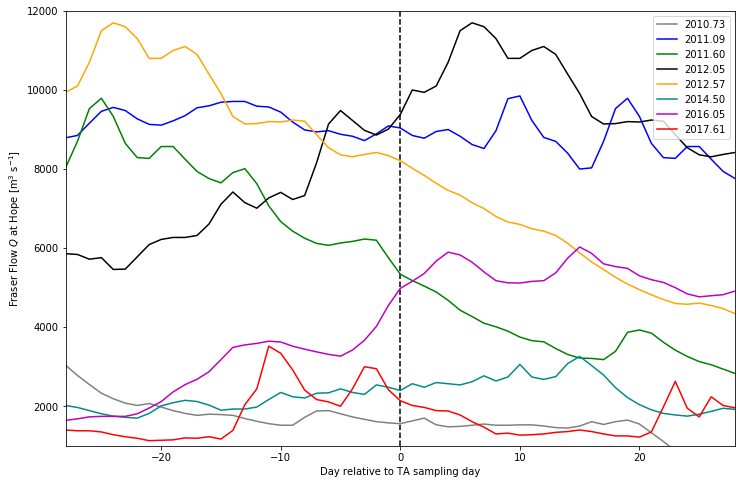

In [6]:
# Make Figure
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot([0, 0], [1000, 12000], 'k--')
ax.set_xlim([-28, 28])
ax.set_ylim([1000, 12000])
ax.set_xlabel('Day relative to TA sampling day')
ax.set_ylabel('Fraser Flow $Q$ at Hope [m$^3$ s$^{-1}$]')

# Loop through cruises
for cruise, station, color in zip(cruises[:-1], stations, colors):
    
    # Plot 40 day flow record
    index = (crid == cruise) & (stn == station) & ((alk_qf == 2) | (alk_qf == 6))
    flowindex = abs(np.array(dates) - datetime(int(cruise), int(mnth[index][0]), int(day[index][0]))).argmin()
    ax.plot(range(-28, 29), flows[flowindex-28:flowindex+29], color=color, label=f'{cruise:.2f}')

ax.legend(loc=1)
plt.show()

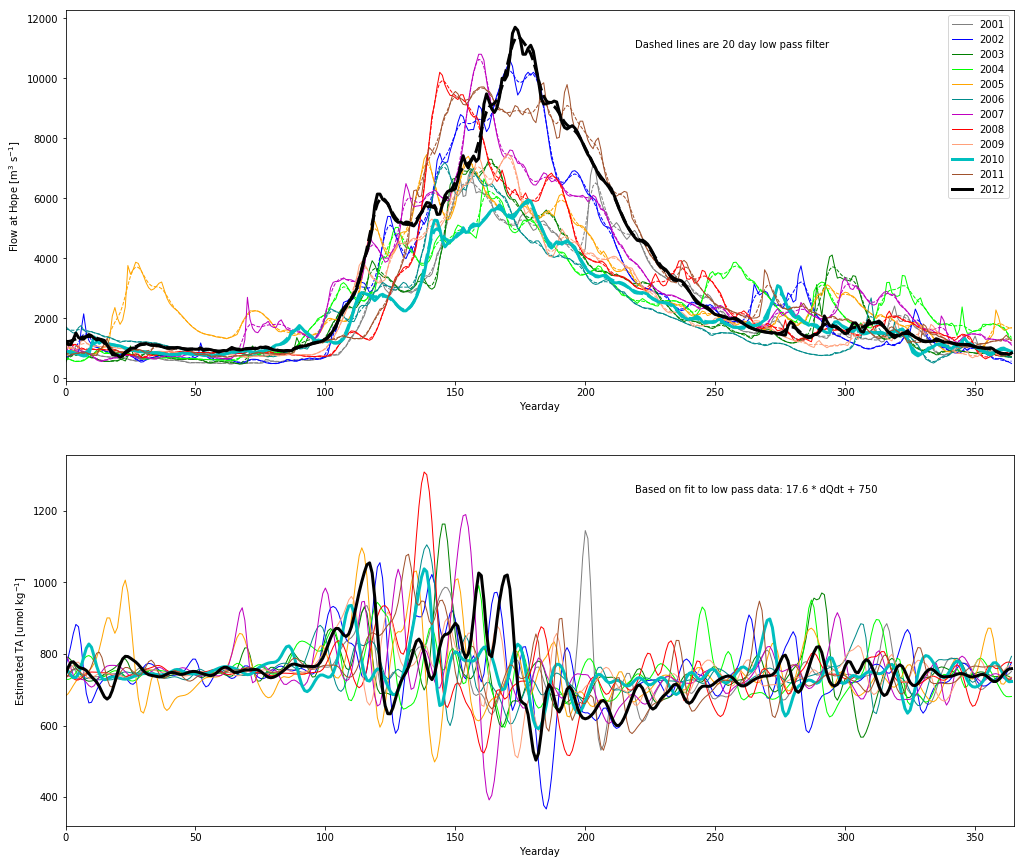

In [7]:
flowlims = [abs(np.array(dates) - parse(date)).argmin() for date in ['2001 Jan 1', '2013 Jan 1']]

dQdt = np.diff(flows_filter)/24

colors = ['gray', 'b', 'g', 'lime', 'orange', 'darkcyan', 'm', 'r', 'lightsalmon', 'c', 'sienna', 'k']

fig, ax = plt.subplots(2, 1, figsize=(17, 15))
ax[0].set_xlim([0, 365])
ax[0].set_xlabel('Yearday')
ax[0].set_ylabel('Flow at Hope [m$^{3}$ s$^{-1}$]')
ax[1].set_xlim([0, 365])
ax[1].set_xlabel('Yearday')
ax[1].set_ylabel('Estimated TA [umol kg$^{-1}$]')
ax[0].text(0.6, 0.9, 'Dashed lines are 20 day low pass filter', transform=ax[0].transAxes)
ax[1].text(0.6, 0.9, 'Based on fit to low pass data: 17.6 * dQdt + 750', transform=ax[1].transAxes)

for year, color in zip(range(2001, 2013), colors):
    if year == 2010 or year == 2012:
        linewidth = 3
    else:
        linewidth = 1
    istart = abs(np.array(dates) - datetime(year, 1, 1)).argmin()
    iend = abs(np.array(dates) - datetime(year, 1, 1) - timedelta(days=365)).argmin()
    ax[0].plot(flows[istart: iend], '-', color=color, label=str(year), linewidth=linewidth)
    ax[0].plot(flows_filter[istart: iend], '--', color=color, linewidth=linewidth)
    ax[1].plot(17.6*dQdt[istart: iend] + 750, '-', color=color, linewidth=linewidth)
ax[0].legend()
plt.show()

In [8]:
# Create new forcing file
Fraser = pd.read_csv(
    '/ocean/bmoorema/research/SOG/SOG-forcing/rivers/Fraser_total_31May2013.dat',
    delim_whitespace=True, names=['year', 'month', 'day', 'flow'],
)
B, A = signal.butter(2, 0.2)
filtered = signal.filtfilt(B, A, Fraser['flow'])
dQdt = 17.6 * np.diff(filtered)/24 + 750
dQdt = pd.DataFrame(np.append(dQdt[0], dQdt), columns=['TA'])
Fraser = Fraser.join(dQdt)

#Fraser.to_csv('/ocean/bmoorema/research/SOG/SOG-forcing/rivers/FraserTA.dat', sep=' ', header=False, index=False)

## Fraser River Buoy Data

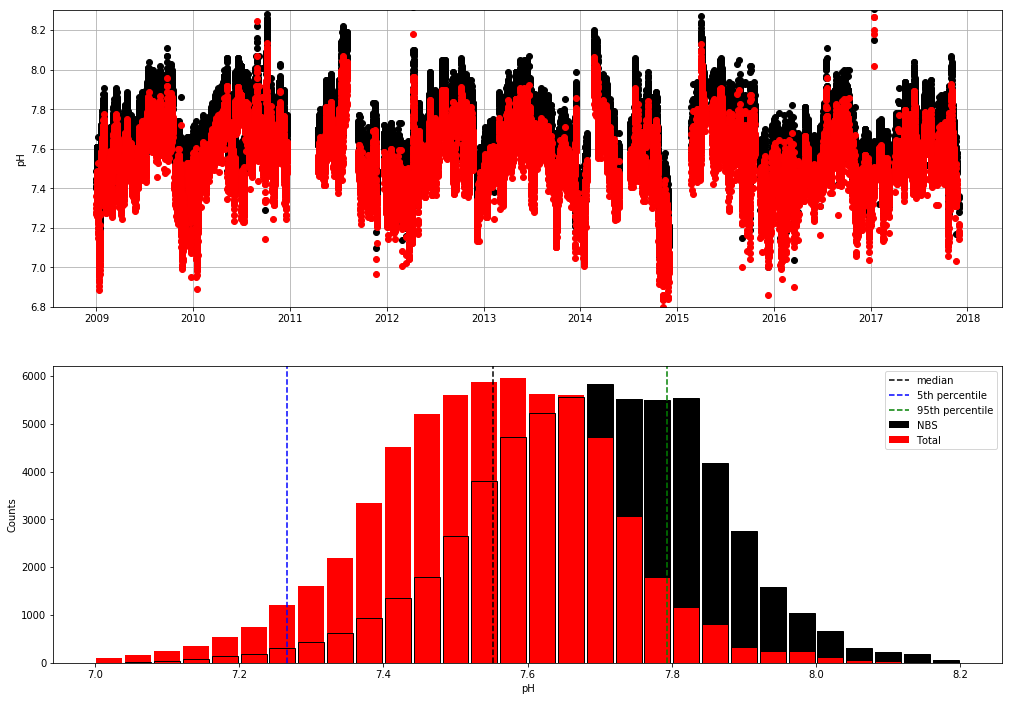

In [9]:
# Plot Buoy Data
buoy = loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')
datetimes = [
    datetime.fromordinal(int(mtime[0])) + timedelta(days=mtime[0]%1) - timedelta(days = 366) for mtime in buoy['ecbuoy'][0][0][4]
]
T = buoy['ecbuoy'][0][0][5]
C = buoy['ecbuoy'][0][0][6] * 1e-3
pH = buoy['ecbuoy'][0][0][16]
S = gsw.conversions.SP_from_C(C, T, 0)
pH_dict = carbonate.FindpHOnAllScales(pH, T, S, 0, scale='NBS')

# pH Stats
median = np.nanmedian(pH_dict['total'])
percentile_5 = np.nanpercentile(pH_dict['total'], 5)
percentile_95 = np.nanpercentile(pH_dict['total'], 95)

# Make Figure
fig, ax = plt.subplots(2, 1, figsize=(17, 12))
ax[0].plot(datetimes, pH_dict['NBS'], 'ko')
ax[0].plot(datetimes, pH_dict['total'], 'ro')
ax[0].set_ylim([6.8, 8.3])
ax[0].set_ylabel('pH')
ax[0].grid()

ax[1].hist(pH_dict['NBS'][~np.isnan(pH_dict['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', label='NBS')
ax[1].hist(pH_dict['total'][~np.isnan(pH_dict['total'])], bins=30, range=[7, 8.2], rwidth=0.9, color='r', label='Total')
ax[1].hist(pH_dict['NBS'][~np.isnan(pH_dict['NBS'])], bins=30, range=[7, 8.2], rwidth=0.9, color='k', fill=False)
ax[1].plot([median, median], [0, 6200], 'k--', label='median')
ax[1].plot([percentile_5, percentile_5], [0, 6200], 'b--', label='5th percentile')
ax[1].plot([percentile_95, percentile_95], [0, 6200], 'g--', label='95th percentile')
ax[1].set_ylim([0, 6200])
ax[1].set_xlabel('pH')
ax[1].set_ylabel('Counts')
ax[1].legend()
plt.show()

## SOG Results

In [10]:
# Load list of results directories
with open('/ocean/bmoorema/research/SOG/SOG-runsets/river_chemistry/run_list.yaml', 'r') as f:
    run_list = yaml.load(f)

In [11]:
# Populate dict fields
TAruns = {
    '72': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '76': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
    '79': {'250': {}, '500': {}, '750': {}, '1000': {}, '1250': {}, 'var': {}},
}

In [101]:
for path in run_list['run_list']:
    TS_phys = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_phys_SOG.out'))
    TS_chem = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_chem_SOG.out'))
    TS_bio = SOG_loader.load_TS(os.path.join(path, 'timeseries/std_bio_SOG.out'))
    key = os.path.split(path)[1]
    year = key.split('_')[0]
    chemstr = key.split('TA')[1].split('pH')
    TA = chemstr[0]
    pH = chemstr[1]
    TAruns[pH][TA][year] = {}
    
    # Extract physics variables
    TAruns[pH][TA][year]['t'] = TS_phys['3 m avg temperature']              # in situ temperature [deg C]
    TAruns[pH][TA][year]['SP'] = TS_phys['3 m avg salinity']                # practical salinity  [PSS 78]
    
    # Calculate and assign TEOS-10 properties
    TAruns[pH][TA][year]['SR'] = gsw.conversions.SR_from_SP(TAruns[pH][TA][year]['SP'])
    TAruns[pH][TA][year]['CT'] = gsw.conversions.CT_from_t(TAruns[pH][TA][year]['SR'], TAruns[pH][TA][year]['t'], 0)
    TAruns[pH][TA][year]['rho'] = gsw.density.rho(TAruns[pH][TA][year]['SR'], TAruns[pH][TA][year]['CT'], 0)
    
    # Extract bio and chem fields
    TAruns[pH][TA][year]['NO3'] = TS_bio['3 m avg nitrate concentration']   # nitrate             [uM]
    TAruns[pH][TA][year]['NH4'] = TS_bio['3 m avg ammonium concentration']  # ammonium            [uM]
    TAruns[pH][TA][year]['Si'] = TS_bio['3 m avg silicon concentration']    # dissolved silica    [uM]
    # dissolved inorganic carbon [umol kg-1]
    TAruns[pH][TA][year]['DIC'] = TS_chem['3 m avg DIC concentration'] * 1e3 / TAruns[pH][TA][year]['rho']
    # total alkalinity [umol kg-1]
    TAruns[pH][TA][year]['TA'] = TS_chem['3 m avg alkalinity'] * 1e3 / TAruns[pH][TA][year]['rho']
    
    # Calculate CO2 parameters
    CO2 = carbonate.calc_carbonate(
        [TAruns[pH][TA][year]['TA'], TAruns[pH][TA][year]['DIC']],          # [TA, DIC]
        (TAruns[pH][TA][year]['NO3'] + TAruns[pH][TA][year]['NH4']) / 16,   # total phosphate (estimated from N)
        TAruns[pH][TA][year]['Si'],                                         # dissolved silica
        TAruns[pH][TA][year]['t'],                                          # in situ temperature
        TAruns[pH][TA][year]['SP'],                                         # practical salinity
        0,                                                                  # pressure
        TAruns[pH][TA][year]['rho'],                                        # density (not sigma)
        params=['TA', 'TC'],
    )
    
    # Assign CO2 parameters
    TAruns[pH][TA][year]['pH'] = CO2['pH']                                  # pH [total scale]
    TAruns[pH][TA][year]['pCO2'] = CO2['pCO2']                              # CO2 partial pressure [uatm]
    TAruns[pH][TA][year]['OmegaA'] = CO2['OmegaA']                          # aragonite saturation stat

In [108]:
years = list(TAruns['72']['var'].keys())
TAs = list(TAruns['72'].keys())
pHs = list(TAruns.keys())

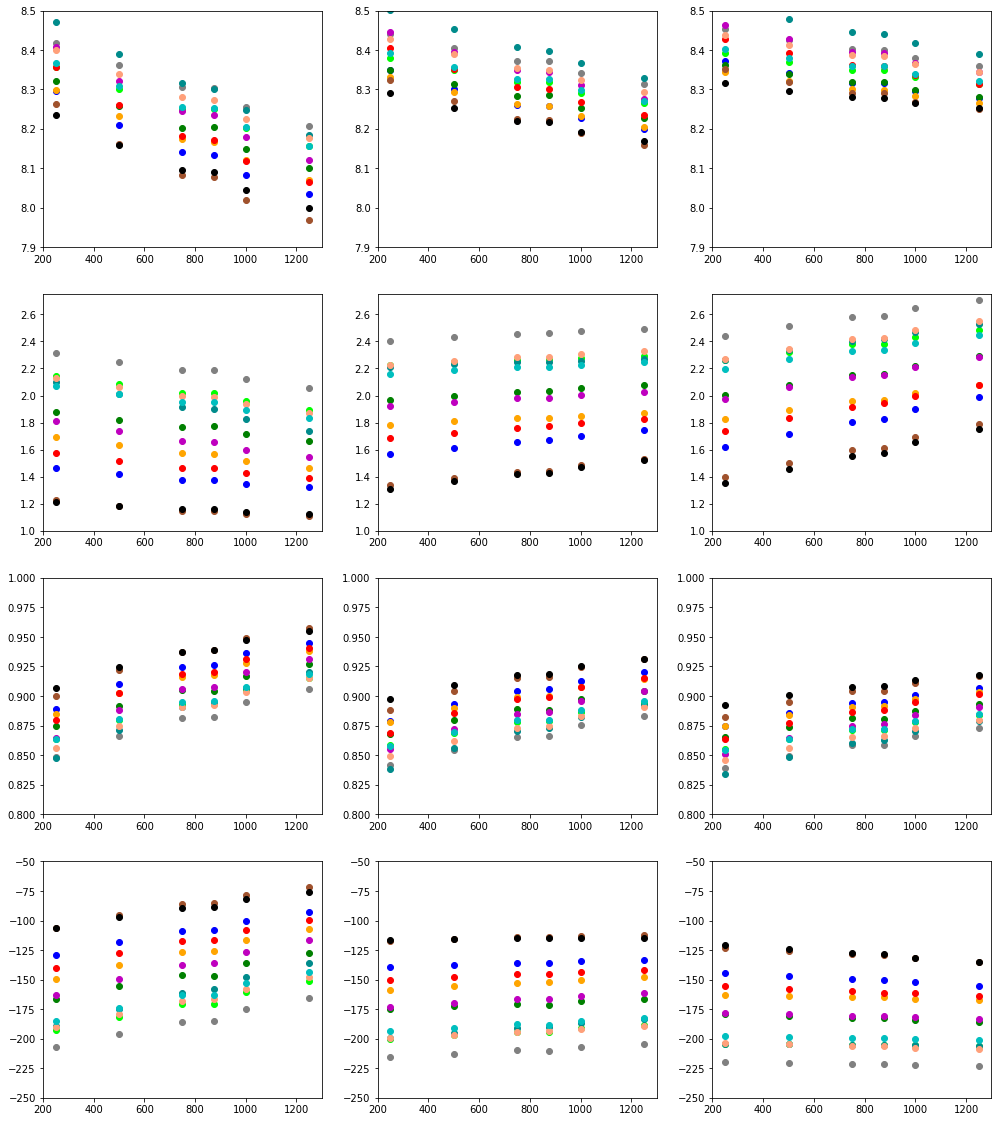

In [129]:

colors = ['gray', 'b', 'g', 'lime', 'orange', 'darkcyan', 'm', 'r', 'lightsalmon', 'c', 'sienna', 'k']

fig, axs = plt.subplots(4, 3, figsize=(17, 20))

params = ['pH', 'OmegaA', 'DICTA', 'DICminusTA']

lims = [[7.9, 8.5], [1, 2.75], [0.8, 1], [-250, -50]]
for row, param, lim in zip(axs, params, lims):
    for ax, pH in zip(row, pHs):
        ax.set_ylim(lim)
        for TA in TAs:
            if TA is 'var':
                x = 875
            else:
                x = int(TA)
            for year, color in zip(years, colors):
                index = TAruns[pH][TA][year]['SP'] < 20
                if param is 'pH':
                    y = TAruns[pH][TA][year]['pH'][index]
                elif param is 'OmegaA':
                    y = TAruns[pH][TA][year]['OmegaA'][index]
                elif param is 'DICTA':
                    y = TAruns[pH][TA][year]['DIC'][index]/TAruns[pH][TA][year]['TA'][index]
                elif param is 'DICminusTA':
                    y = TAruns[pH][TA][year]['DIC'][index]-TAruns[pH][TA][year]['TA'][index]
                ax.plot(x, y.mean(), 'o', color=color)